# 基于return based方法对比资产/因子配置的结果

In [143]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.plotting import plot_efficient_frontier

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

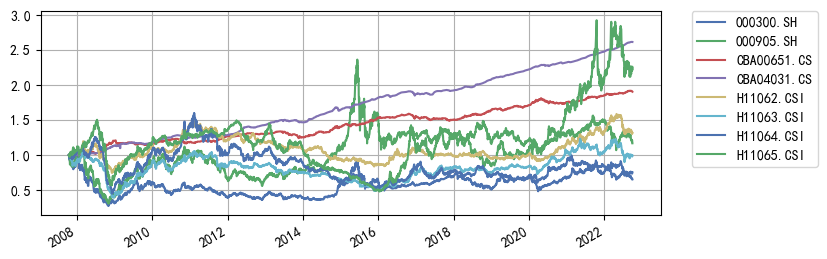

In [144]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
(asset_data_raw.dropna()/asset_data_raw.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [145]:
asset_alpha = pd.read_csv(os.path.join(this_path, '../data/assets/asset_alpha.csv'), index_col=0)
asset_alpha.index = pd.to_datetime(asset_alpha.index)
asset_alpha_pca = pd.read_csv(os.path.join(this_path, '../data/assets/asset_alpha_pca.csv'), index_col=0)
asset_alpha_pca.index = pd.to_datetime(asset_alpha_pca.index)

In [146]:
def alpha2Gain(alpha, scale=0.1):
    gain = pd.DataFrame(columns=alpha.columns)
    for i in alpha.index:
        tmp = alpha.loc[:i]
        gain.loc[i] = (tmp.rank().iloc[-1]-1) / (tmp.shape[0]-1)
    gain = (1-gain) / (1/scale/2) - scale + 1
    return gain


In [147]:
scale = 0.5
asset_alpha_gain = alpha2Gain(asset_alpha, scale=scale)
asset_alpha_pca_gain = alpha2Gain(asset_alpha_pca, scale=scale)

In [148]:
class MvoStrategy(Strategy):
    def __init__(self, asset_raw_data=None, asset_alpha=None, weight_bounds=[0, 0.4], total_weight=[0.99, 1], target_return=None, target_risk=None, max_sharp=False, **kwargs):
        super().__init__()
        assert not asset_raw_data is None
        self._asset_raw_data = asset_raw_data
        self._asset_alpha = asset_alpha
        self._weight_bounds = weight_bounds
        self._total_weight = total_weight
        self._target_return = target_return
        self._target_risk = target_risk
        self._max_sharp = max_sharp

    def run(self, id_date, asset_data):
        mu = expected_returns.mean_historical_return(self._asset_raw_data.loc[:id_date].iloc[-252*3:], returns_data=False)
        if not self._asset_alpha is None:
            mu = mu + mu.abs() * (self._asset_alpha.loc[asset_data.index[-1]].reindex(asset_data.columns).fillna(1) - 1)
        # print(mu)
        # sys.exit(1)
        s = risk_models.sample_cov(asset_data, returns_data=False)
        ef = EfficientFrontier(mu, s, weight_bounds=self._weight_bounds)

        if self._total_weight:
            sector_mapper = {a:'all' for a in asset_data.columns}
            ef.add_sector_constraints(sector_mapper, sector_lower={'all':self._total_weight[0]}, sector_upper={'all':self._total_weight[1]})

        # plot_efficient_frontier(ef)
        # sys.exit(1)
        try:
            if self._max_sharp:
                _ = ef.max_sharpe()
            elif self._target_return:
                _ = ef.efficient_return(self._target_return)
            elif self._target_risk:
                _ = ef.efficient_risk(self._target_risk)
            weights = ef.clean_weights()
        except Exception as e:
            print(e)
            weights = [np.nan] * asset_data.shape[1]
        # print(weights)
        # sys.exit(1)

        return pd.Series(weights, index=asset_data.columns)

## 1. max sharpe

In [149]:
date_range = [datetime(2015,1,30), datetime(2021,12,31)]
asset_max_sharpe_backtest = BacktestManager(
    MvoStrategy(max_sharp=True, asset_raw_data=asset_data_raw), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
asset_max_sharpe_backtest.run()

100%|██████████| 1686/1686 [00:09<00:00, 183.84it/s]


<AxesSubplot:>

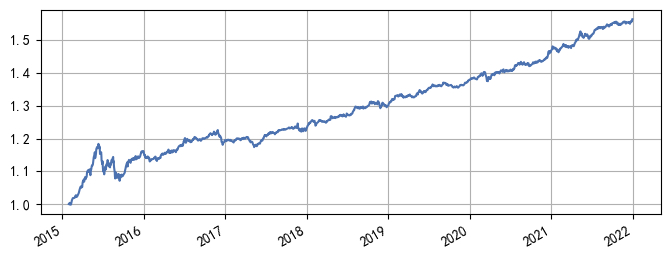

In [150]:
asset_max_sharpe_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

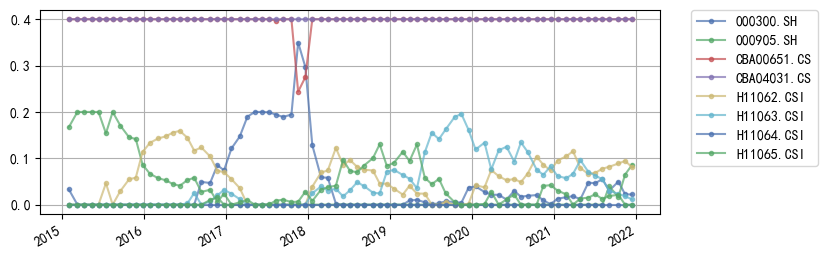

In [151]:
weights = pd.concat(list(asset_max_sharpe_backtest._historcial_weights.values()), axis=1).T
weights.index = list(asset_max_sharpe_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [152]:
factor_max_sharpe_backtest = BacktestManager(
    MvoStrategy(max_sharp=True, asset_alpha=asset_alpha_gain, asset_raw_data=asset_data_raw), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
factor_max_sharpe_backtest.run()

100%|██████████| 1686/1686 [00:08<00:00, 205.51it/s]


<AxesSubplot:>

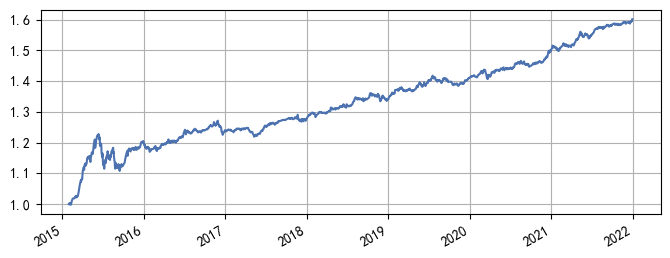

In [153]:
factor_max_sharpe_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

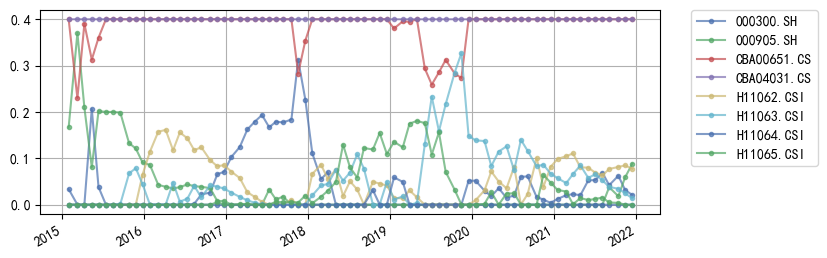

In [154]:
weights = pd.concat(list(factor_max_sharpe_backtest._historcial_weights.values()), axis=1).T
weights.index = list(factor_max_sharpe_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [155]:
factor_pca_max_sharpe_backtest = BacktestManager(
    MvoStrategy(max_sharp=True, asset_alpha=asset_alpha_pca_gain, asset_raw_data=asset_data_raw), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
factor_pca_max_sharpe_backtest.run()

100%|██████████| 1686/1686 [00:08<00:00, 191.91it/s]


<AxesSubplot:>

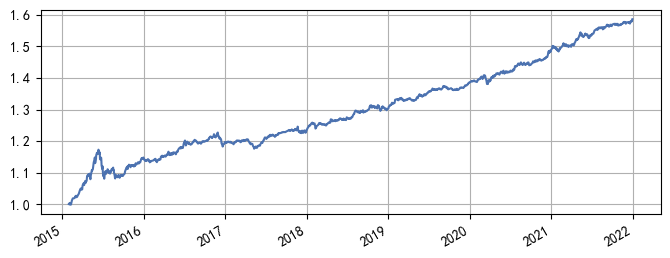

In [156]:
factor_pca_max_sharpe_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

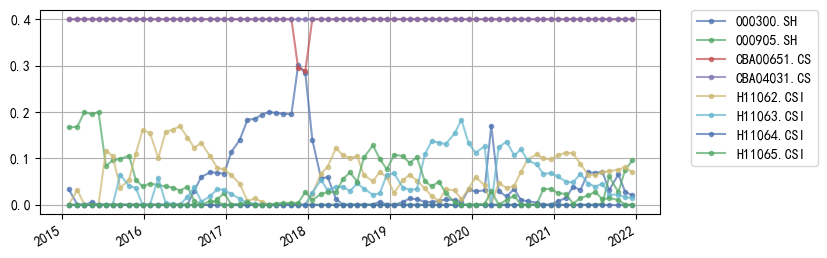

In [157]:
weights = pd.concat(list(factor_pca_max_sharpe_backtest._historcial_weights.values()), axis=1).T
weights.index = list(factor_pca_max_sharpe_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

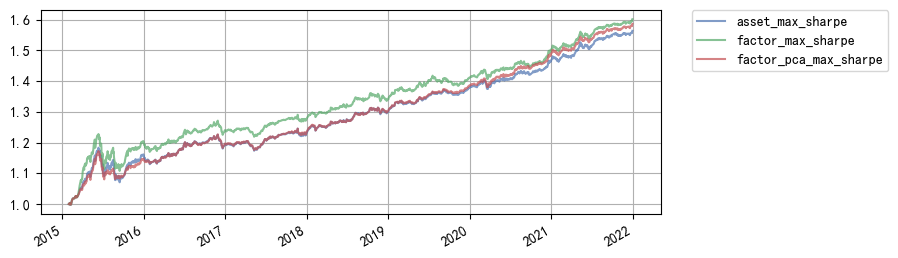

In [158]:
max_sharpe_values = pd.DataFrame({
    'asset_max_sharpe': asset_max_sharpe_backtest.getHistoricalValue(scale=True), 
    'factor_max_sharpe': factor_max_sharpe_backtest.getHistoricalValue(scale=True), 
    'factor_pca_max_sharpe': factor_pca_max_sharpe_backtest.getHistoricalValue(scale=True), 
})
max_sharpe_values.plot(figsize=(8,3), grid=True, alpha=0.7)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [159]:
# sharpe
sharpe = ((max_sharpe_values.iloc[-1]/max_sharpe_values.iloc[0]) ** (252/max_sharpe_values.shape[0]) - 1 - 0.015) / (max_sharpe_values.pct_change().std() * 252**0.5)
sharpe

asset_max_sharpe         1.378349
factor_max_sharpe        1.323665
factor_pca_max_sharpe    1.633012
dtype: float64

## 2. MVO

In [160]:
date_range = [datetime(2015,1,30), datetime(2021,12,31)]
asset_mvo_backtest = BacktestManager(
    MvoStrategy(target_risk=0.05, asset_raw_data=asset_data_raw), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
asset_mvo_backtest.run()

100%|██████████| 1686/1686 [00:08<00:00, 199.62it/s]


<AxesSubplot:>

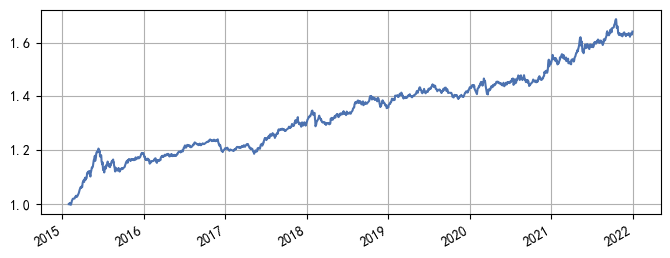

In [161]:
asset_mvo_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

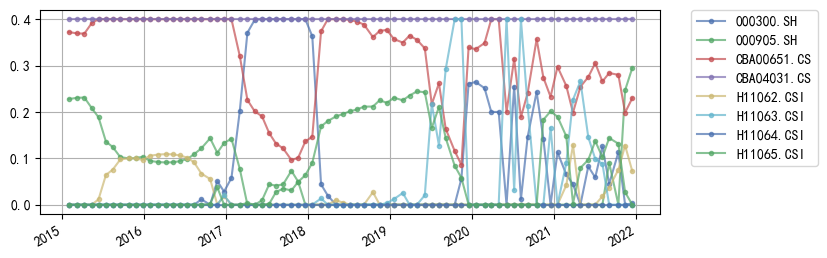

In [162]:
weights = pd.concat(list(asset_mvo_backtest._historcial_weights.values()), axis=1).T
weights.index = list(asset_mvo_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [163]:
factor_mvo_backtest = BacktestManager(
    MvoStrategy(target_risk=0.05, asset_alpha=asset_alpha_gain, asset_raw_data=asset_data_raw), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
factor_mvo_backtest.run()

100%|██████████| 1686/1686 [00:08<00:00, 207.89it/s]


<AxesSubplot:>

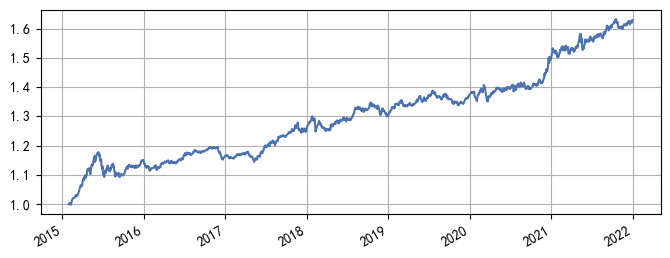

In [164]:
factor_mvo_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

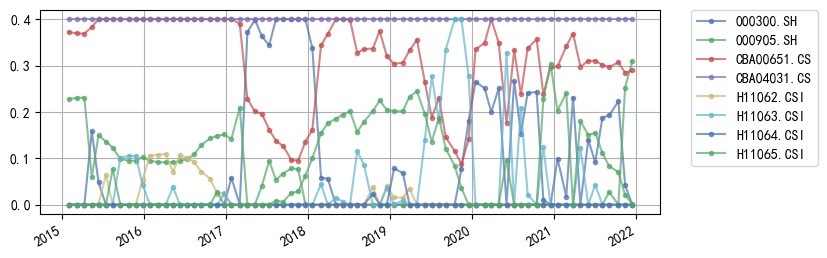

In [165]:
weights = pd.concat(list(factor_mvo_backtest._historcial_weights.values()), axis=1).T
weights.index = list(factor_mvo_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [166]:
factor_pca_mvo_backtest = BacktestManager(
    MvoStrategy(target_risk=0.05, asset_alpha=asset_alpha_pca_gain, asset_raw_data=asset_data_raw), 
    asset_data_raw, 
    date_range = date_range, 
    frequency = 22, 
    look_back = 252, 
)
factor_pca_mvo_backtest.run()

100%|██████████| 1686/1686 [00:09<00:00, 178.38it/s]


<AxesSubplot:>

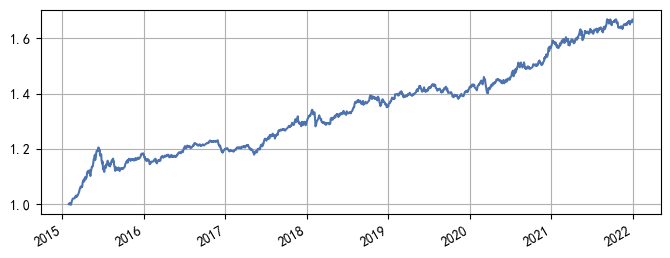

In [167]:
factor_pca_mvo_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

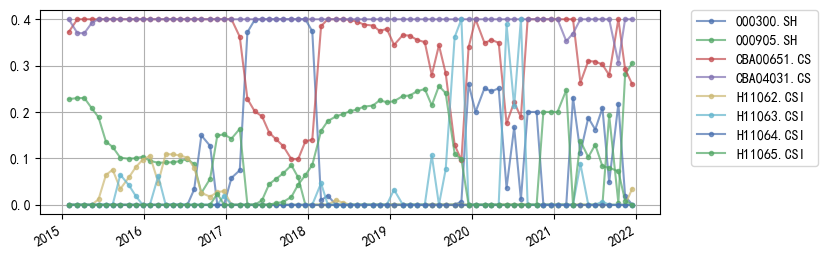

In [168]:
weights = pd.concat(list(factor_pca_mvo_backtest._historcial_weights.values()), axis=1).T
weights.index = list(factor_pca_mvo_backtest._historcial_weights.keys())
weights.plot(figsize=(8,3), grid=True, alpha=0.7, style='.-')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

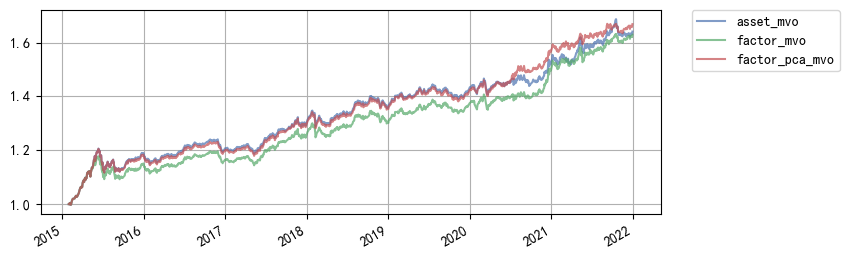

In [169]:
mvo_values = pd.DataFrame({
    'asset_mvo': asset_mvo_backtest.getHistoricalValue(scale=True), 
    'factor_mvo': factor_mvo_backtest.getHistoricalValue(scale=True), 
    'factor_pca_mvo': factor_pca_mvo_backtest.getHistoricalValue(scale=True), 
})
mvo_values.plot(figsize=(8,3), grid=True, alpha=0.7)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [170]:
# sharpe
sharpe = ((mvo_values.iloc[-1]/mvo_values.iloc[0]) ** (252/mvo_values.shape[0]) - 1 - 0.015) / (mvo_values.pct_change().std() * 252**0.5)
sharpe

asset_mvo         1.163431
factor_mvo        1.162740
factor_pca_mvo    1.273308
dtype: float64